In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm
import statistics
#from scipy import special
import scipy.optimize as so
from sympy import *


In [3]:
from functions import *

## CREATION OF OBSERVATION FILES 

i am inventig an array of observations, représenting measurements of temperature in the soil at 5 cm and 10 cm depth. Then i used something to sample it at the wanted frequency, for the data assimilation part i will try to observe which frequency of observation gives enough information to correct the model and give an appropriate solution. 

In [4]:
 #paramètres 
limt=82*1
dt=1/60
tt=np.arange(0,limt,dt)
freq=60  # minutes 

limx=100
dx=1
xx=np.arange(0,limx,dx)

s=5  #standard dev   gaussian
mu=0   #moyenne gaussienne 
K=0.6  #thermal conductivity of soil

In [5]:
#measurements, truth of temperature and time of the measurements 
mes_5cm, true_5cm, tt_obs_5cm= obs_5(dt,limt,freq)

mes_10cm, true_10cm, tt_obs_10cm= obs_10(dt,limt,freq)

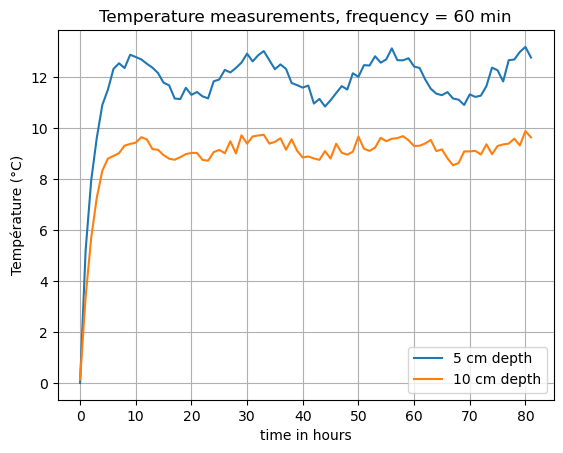

In [6]:
plt.plot(tt_obs_5cm, mes_5cm,label='5 cm depth')
plt.plot(tt_obs_10cm, mes_10cm,label='10 cm depth')

plt.title('Temperature measurements, frequency = '+ str(freq)+' min')
plt.xlabel('time in hours')
plt.ylabel('Température (°C)')
plt.legend()
plt.grid()

## DATA ASSIMILATION - 3D VAR


In [80]:
### parameters for 3DVAR

## Type and timing of observations
nvarobs = [5,10]            ## observed variables   mesure à 10,  et 5 cm 
nobs = len(nvarobs)
assim_steps =tt_obs_10cm   # range(0,50,5)  #fréquence d'assimilation 1 fois par heure 
#print(assim_steps)
nassim = len(assim_steps)
#assim_windows = 50   # 50
#_______________________________________________
## Observation operator
hobs = np.zeros((nobs,len(xx)))
j=0
for i in range(nobs):
    hobs[j,nvarobs[i]] = 1 #binaire 1 avec obs 0 aucune obs
    j += 1
print(np.shape(hobs))
#_____________________________________________________________
#observations: mesure de température 
yobs=np.vstack((mes_5cm,mes_10cm))
#observation covariance matrix
Robs=0.5**2

#________________________________________
#less and less precise the deeper it is 
#Pmat
Pmat=np.linspace(0.5,0.01,len(xx))   #juste les termes diagonaux 
#B = np.eye(3)/(xstd**2)

#____________________________________________________________________________________________



(2, 100)


In [ ]:
#euler forward scheme gives prevision of temperature in depth for the next time step using state vector x
def euler_f_assim(x,dt,dx,K):
    #it moment ou on commence la simulation numéro de pas de temps        
    Tf=x #vecteur température en profondeur pour un pas de temps
    Tz=np.zeros(len(x))
    for j in range(1,len(x)-1):
        Tz[j]=Tf[j]+(K*dt/(dx**2))*(Tf[j+1]+Tf[j-1]-2*Tf[j])
       
    return Tz #propage pour le pas de temps prochain 



Fonctionne pas .... quel est le pb ??? 

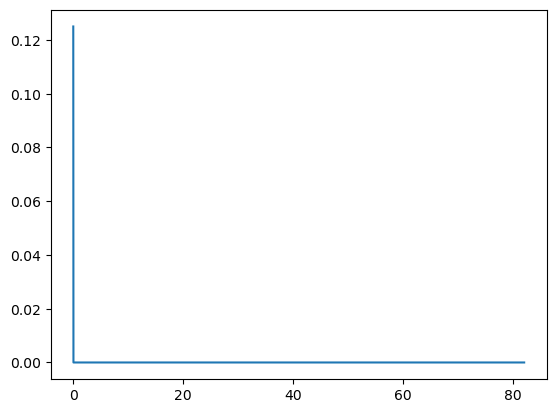

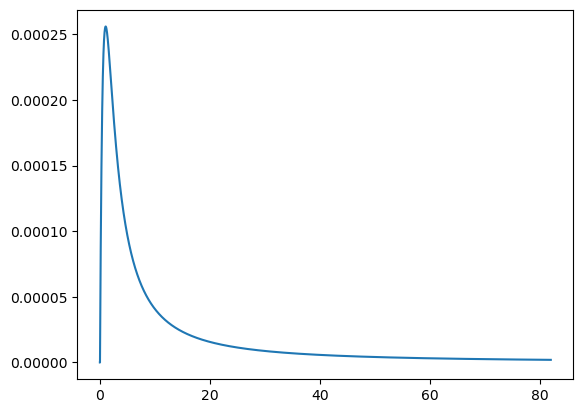

In [84]:
l = np.zeros((Nt,Nx))   # stocke résultats du modèle d'origine 
l[:,0]=temp_cycle(tt,dt)

for it in range(Nt-1):
    d=l[it,:]#champ de température au temps t  
    l[it+1,:] = euler_f_assim(d,dt,dx,K)
   
plt.plot(tt[:],l[:,0],label='Model') 
plt.show()
plt.plot(tt[:],l[:,2],label='Model')


In [82]:
Nt=len(tt)
Nx=len(xx)

#_________________________________

xb_save = np.zeros((Nt,Nx))   # stocke résultats du modèle d'origine 
x_save = np.zeros((Nt,Nx))   #stocke résultats du modèle avec assimilation de données 
#xb_save[0,:] = gauss(xx, mu, s)
xb_save[:,0]=temp_cycle(tt,dt)# valeur au pas de temps 0   #backgroud
Var_save = np.zeros((Nt+1,Nx))  #valeur de la variance 
Var_save[0,:] = Pmat

xb=xb_save[0,:]
for it in range(Nt-1):
  
    
#FORECAST
    #champ de température au temps t   background 
    xb=euler_f_assim(xb,dt,dx,K)# prévision à t+1 en faisant tourner le modèle 
#si H est changé à chaque pas de temps faire qqch 
    
    iobs=0
    if tt[it] in tt_obs_10cm : #ANALYSE 
        yo=yobs[:,iobs]
        res = so.minimize(CostFunction,xb,args=(xb,yo,Pmat,Robs,hobs),  # minimize pour le paramètre xin 
                   method='Powell',
                   options={'maxiter': 30})
        xb=res['x']
        #Pmat= nb
        iobs=+1
        
        #xa_save[iobs,:] = xb
    x_save[it+1,:] = xb
        #Var_save[:,it+1] = np.diag(Pmat)





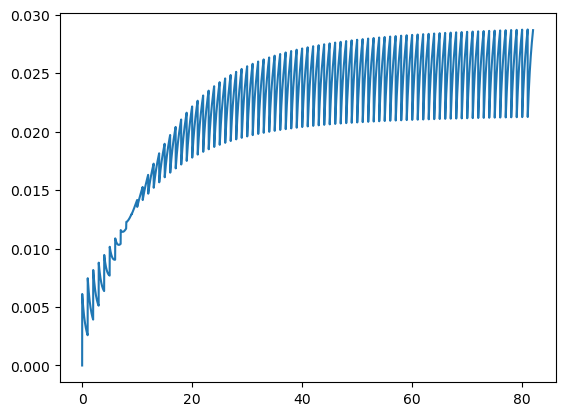

In [83]:
plt.plot(tt,x_save[:,5])